# Data Encoding

In the following notebook, we follow the IBM Course `Quantum Machine Learning`, and in particular discuss several ways of data encoding in quantum machine learning.

## Basis encoding

Basis encoding encodes classical P-bit strings into the computational state of a P-qubit system. As an example, let's encode the vector (5,7,0). The binary strings are given by
* 5 $\to$ 0101
* 7 $\to$ 0111
* 0 $\to$ 0000

and its 12-qubit quantum state is given by $|010101110000\rangle$. The code below converts the data vector (5,7,0) to a quantum state, and is generalized to do so for other single-digit features.

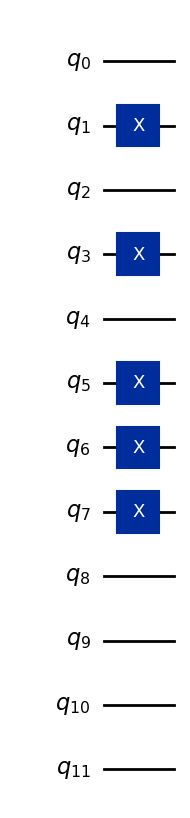

In [1]:
from qiskit import QuantumCircuit
 
# Data point to encode
x = 5  # binary: 0101
y = 7  # binary: 0111
z = 0  # binary: 0000
 
# Convert each to 4-bit binary list
x_bits = [int(b) for b in format(x, "04b")]  # [0,1,0,1]
y_bits = [int(b) for b in format(y, "04b")]  # [0,1,1,1]
z_bits = [int(b) for b in format(z, "04b")]  # [0,0,0,0]
 
# Combine all bits
all_bits = x_bits + y_bits + z_bits  # [0,1,0,1,0,1,1,1,0,0,0,0]
 
# Initialize a 12-qubit quantum circuit
qc = QuantumCircuit(12)
 
# Apply x-gates where the bit is 1
for idx, bit in enumerate(all_bits):
    if bit == 1:
        qc.x(idx)
 
qc.draw("mpl")

For the vector (4,8,5) this would be

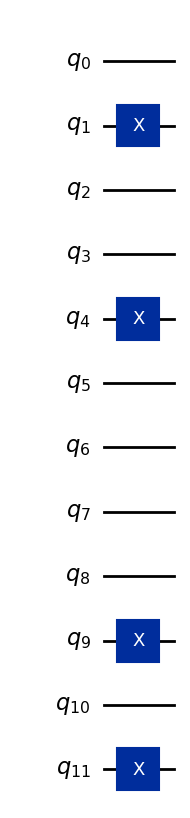

In [2]:
# Data point to encode
x = 4  # binary: 0100
y = 8  # binary: 1000
z = 5  # binary: 0101
 
# Convert each to 4-bit binary list
x_bits = [int(b) for b in format(x, "04b")]  # [0,1,0,0]
y_bits = [int(b) for b in format(y, "04b")]  # [1,0,0,0]
z_bits = [int(b) for b in format(z, "04b")]  # [0,1,0,1]
 
# Combine all bits
all_bits = x_bits + y_bits + z_bits  # [0,1,0,0,1,0,0,0,0,1,0,1]
 
# Initialize a 12-qubit quantum circuit
qc = QuantumCircuit(12)
 
# Apply x-gates where the bit is 1
for idx, bit in enumerate(all_bits):
    if bit == 1:
        qc.x(idx)
 
qc.draw("mpl")

## Amplitude encoding

Another method is amplitude encoding, where an N-dimensional data vector $\vec{x}^{(j)}$ is encoded as an amplitude of a n-qubit quantum state $|\psi_x\rangle$ as
\begin{equation}
|\psi_x^{(j)}\rangle = \frac{1}{\alpha}\sum_{i=1}^{N} x_i^{(j)}|i\rangle
\end{equation}
where $x_i^{(j)}$ is the $i^{\rm th}$ element of $\vec{x}^{(j)}$, $|i\rangle$ is the $i^{\rm th}$ computational basis state, $\alpha$ the normalization calculated by $\sum_{i=1}^N |x_i^{(j)}|^2=\alpha^2$. We need $n \geq \log_2(N)$ qubits for $|i\rangle$.

Let's look at the example $\vec{x}^{(1)}=(4,8,5)$ which becomes
\begin{equation}
|\psi (\vec{x}^{(1)}\rangle = \frac{1}{\sqrt{105}} (4|00\rangle + 8 |01\rangle +5|10\rangle +0 |11\rangle)
\end{equation}

In Qiskit this state can be prepared as:

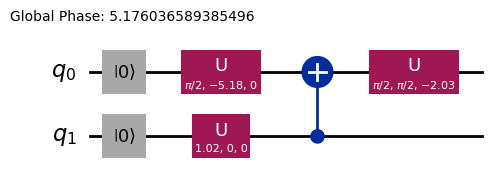

In [3]:
import math
 
desired_state = [
    1 / math.sqrt(105) * 4,
    1 / math.sqrt(105) * 8,
    1 / math.sqrt(105) * 5,
    1 / math.sqrt(105) * 0,
]
 
qc = QuantumCircuit(2)
qc.initialize(desired_state, [0, 1])
 
qc.decompose(reps=5).draw(output="mpl")

As a second example, we look at $\vec{x}=(9,8,6,2,9,2)$. The normalization is $\alpha=\sqrt{270}$ and $n\geq \log_2(6) \approx 2.58$, so we need $n=3$ qubits. Hence, we get
\begin{equation}
|\psi(\vec{x})\rangle = \frac{1}{\sqrt{270}}(9|000\rangle + 8 |001\rangle + 6|010\rangle + 2|011\rangle + 9 |100\rangle + 2|101\rangle + 0 |110\rangle + 0|111\rangle)
\end{equation}

The coded version would be

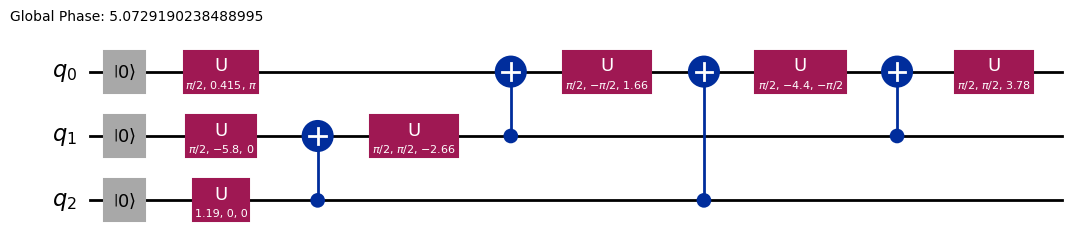

In [4]:
desired_state = [
    1 / math.sqrt(270) * 9,
    1 / math.sqrt(270) * 8,
    1 / math.sqrt(270) * 6,
    1 / math.sqrt(270) * 2,
    1 / math.sqrt(270) * 9,
    1 / math.sqrt(270) * 2,
    1 / math.sqrt(270) * 0,
    1 / math.sqrt(270) * 0,
]
 
qc = QuantumCircuit(3)
qc.initialize(desired_state, [0, 1, 2])
 
qc.decompose(reps=8).draw(output="mpl")

While this case was still possible by hand, we would like to automate the process of amplitude encoding. In the following, we will write some functions to automatically initialize amplitude encoded states.

In [5]:
def norm(vec):
    alpha = sum([i**2 for i in vec])
    return math.sqrt(alpha)

def calc_n(vec):
    nr_entries = len(vec)
    n = math.ceil(math.log(nr_entries, 2))
    return n

def desired_state(vec):
    fac = 1/norm(vec)
    state = [fac*i for i in vec]
    nr_basis_states = 2**calc_n(vec)
    if len(state)<nr_basis_states:
        for ix in range(len(state),nr_basis_states):
            state.append(0)
    return state

def run_encoding(vector,reps):
    state = desired_state(vector)
    n = calc_n(vector)
    q_list = list(range(n))
    
    qc = QuantumCircuit(n)
    qc.initialize(state, q_list)
 
    return qc.decompose(reps=reps).draw(output="mpl")

As an example, let's take $\vec{x}=(4,8,5,9,8,6,2,9,2,5,7,0,3,7,5)$:

4


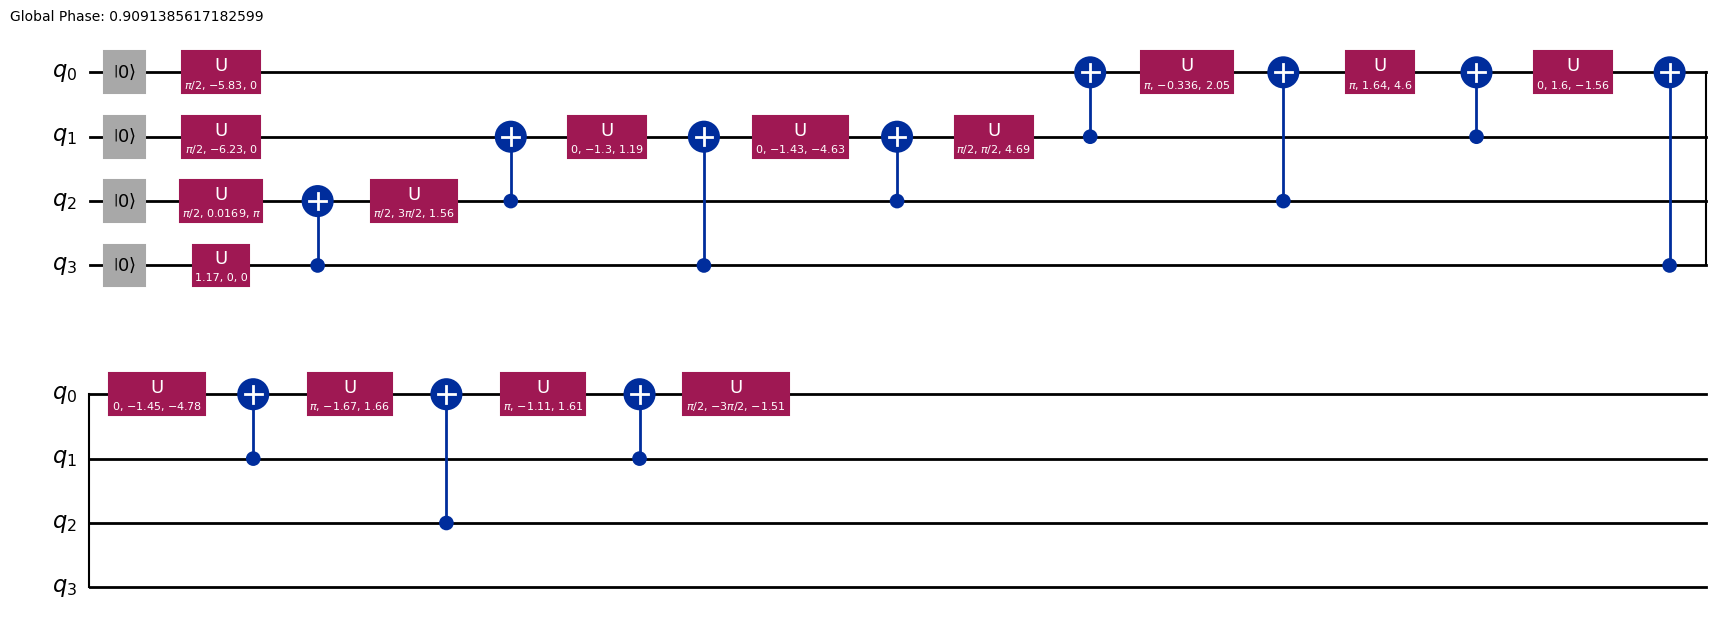

In [6]:
vector = [4,8,5,9,8,6,2,9,2,5,7,0,3,7,5]

print(calc_n(vector))
state = desired_state(vector)

run_encoding(state,16)

## Angle encoding

Angle encoding is particularly interesting for QML models using Pauli feature maps, such as QSVMs or VQCs. It is closely related to phase encoding and dense angle encoding, which will be discussed below. Angle encoding is a rotation in $\theta$ (rotation away from the z axis) by a $R_x$ or $R_y$ gate. Most commonly is the $R_y$ which will use in the following. As an example, let's encode a single ($k^{\rm th}$ feature from the $j^{\rm th}$ data vector in a dataset $\vec{x}^{(j)}_k:
\begin{equation}
|\vec{x}^{(j)}_k\rangle R_y(\theta = \vec{x}_k^{(j)})|0\rangle = \cos(\frac{\vec{x}_k^{(j)}}{2})|0\rangle + \sin(\frac{\vec{x}_k^{(j)}}{2})|1\rangle
\end{equation}

Some characteristics of angle encoding are:
* each feature is mapped to a corresponding qubit $\vec{x}_k^{(j)}\to Q_k$ and the qubit is in a product state
* one numerical value encoded at a time, rather than a whole set of features from a data point
* $n$ qubits required for N data features, where $n\leq N$ (with $=$ being most common)
* resulting circuit is a constant depth (typ. depth is 1 prior to transpilation) ??
* with $R_y$, we create real-valued quantum states

Advice: First rescale data to $\vec{x}_k^{(j)}\in (0,2\pi]$, preventing information loss and unwanted effects

In the following, we rotate $|0\rangle$ to encode $\vec{x}_k^{(j)}=\frac12 \pi$

In [7]:
from qiskit.quantum_info import Statevector
from math import pi
 
qc = QuantumCircuit(1)
state1 = Statevector.from_instruction(qc)
qc.ry(pi / 2, 0)  # Phase gate rotates by an angle pi/2
state2 = Statevector.from_instruction(qc)
states = state1, state2

We visualise the encoding procedure with the following code that is projecting the encoding onto the Bloch sphere

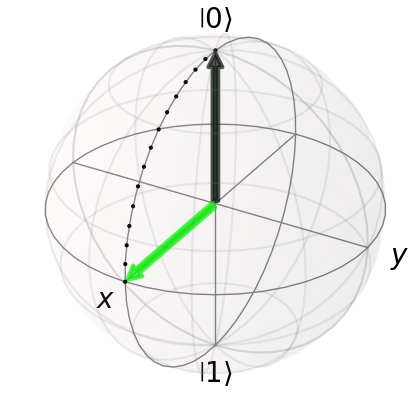

In [8]:
import numpy as np
from qiskit.visualization.bloch import Bloch
from qiskit.visualization.state_visualization import _bloch_multivector_data
 
 
def plot_Nstates(states, axis, plot_trace_points=True):
    """This function plots N states to 1 Bloch sphere"""
    bloch_vecs = [_bloch_multivector_data(s)[0] for s in states]
 
    if axis is None:
        bloch_plot = Bloch()
    else:
        bloch_plot = Bloch(axes=axis)
 
    bloch_plot.add_vectors(bloch_vecs)
 
    if len(states) > 1:
 
        def rgba_map(x, num):
            g = (0.95 - 0.05) / (num - 1)
            i = 0.95 - g * num
            y = g * x + i
            return (0.0, y, 0.0, 0.7)
 
        num = len(states)
        bloch_plot.vector_color = [rgba_map(x, num) for x in range(1, num + 1)]
 
    bloch_plot.vector_width = 3
    bloch_plot.vector_style = "simple"
 
    if plot_trace_points:
 
        def trace_points(bloch_vec1, bloch_vec2):
            # bloch_vec = (x,y,z)
            n_points = 15
            thetas = np.arccos([bloch_vec1[2], bloch_vec2[2]])
            phis = np.arctan2(
                [bloch_vec1[1], bloch_vec2[1]], [bloch_vec1[0], bloch_vec2[0]]
            )
            if phis[1] < 0:
                phis[1] = phis[1] + 2 * pi
            angles0 = np.linspace(phis[0], phis[1], n_points)
            angles1 = np.linspace(thetas[0], thetas[1], n_points)
 
            xp = np.cos(angles0) * np.sin(angles1)
            yp = np.sin(angles0) * np.sin(angles1)
            zp = np.cos(angles1)
            pnts = [xp, yp, zp]
            bloch_plot.add_points(pnts)
            bloch_plot.point_color = "k"
            bloch_plot.point_size = [4] * len(bloch_plot.points)
            bloch_plot.point_marker = ["o"]
 
        for i in range(len(bloch_vecs) - 1):
            trace_points(bloch_vecs[i], bloch_vecs[i + 1])
 
    bloch_plot.sphere_alpha = 0.05
    bloch_plot.frame_alpha = 0.15
    bloch_plot.figsize = [4, 4]
 
    bloch_plot.render()
 
 
plot_Nstates(states, axis=None, plot_trace_points=True)

If we extend angle encoding to encoding N features into the rotation angles of n qubits, e.g. for $\vec{x}^{(j)} = (x_1,...,x_N)$, the encoded product state looks like
\begin{align}
|\vec{x}^{(j)}\rangle &= \otimes_{k=1}^N \cos(\vec{x}^{(j)}_k)|0\rangle + \sin(\vec{x}^{(j)}_k)|1\rangle\\
&=\otimes_{k=1}^N R_y(2\vec{x}^{(j)}_k)|0\rangle
\end{align}

In Qiskit, we would write for a state $\vec{x}=(0,\pi/2,\pi/4)$

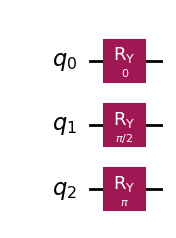

In [9]:
qc = QuantumCircuit(3)
qc.ry(0, 0)
qc.ry(2 * math.pi / 4, 1)
qc.ry(2 * math.pi / 2, 2)
qc.draw(output="mpl")

In [10]:
psi = Statevector(qc)
psi.draw("latex")

<IPython.core.display.Latex object>

## Phase encoding

The phase angle for phase encoding is a real-valued angle about the z-axis from the +x-axis. The phase rotation is given by $P(\phi)=e^{i\phi/2}R_z(\phi)$. Some characteristics are:
* data should be rescaled to $\vec{x}^{(j)}_k\in (0,2\pi]$ to avoid information loss and unwanted effects
* In practise, a state is initialized using a Hadamard gate, followed by the phase encoding:
\begin{equation}
|\vec{x}^{(j)}_k\rangle = P(\phi=\vec{x}^{(j)}_k)|+\rangle = \frac{1}{\sqrt{2}} (|0\rangle + e^{i\vec{x}^{(j)}_k}|1\rangle)
\end{equation}
* phase encoding maps $\vec{x}^{(j)}_k$ features to $Q_k$ qubit, resulting in n qubits for N=n features. The phase encoded multi-qubit state is a product state of the form
\begin{equation}
|\vec{x}^{(j)}\rangle = \otimes_{k=1}^N P_k(\phi=\vec{x}^{(j)}_k)|+\rangle^{\otimes N}=\frac{1}{\sqrt{2^N}}\otimes_{k=1}^N (|0\rangle + e^{i\vec{x}^{(j)}_k}|1\rangle)
\end{equation}

In Qiskit, we implement $\vec{x}^{(j)}_k=\pi/2$ as

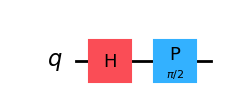

In [11]:
qc = QuantumCircuit(1)
qc.h(0)  # Hadamard gate rotates state down to Bloch equator
state1 = Statevector.from_instruction(qc)
 
qc.p(pi / 2, 0)  # Phase gate rotates by an angle pi/2
state2 = Statevector.from_instruction(qc)
 
states = state1, state2
 
qc.draw("mpl", scale=1)

which can be visualised as before with

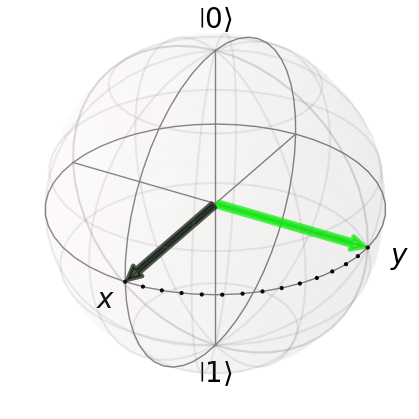

In [12]:
plot_Nstates(states, axis=None, plot_trace_points=True)

For the vector $\vec{x}=(4,8,5,9,8,6,2,9,2,5,7,0), we would automize the code a bit more to

In [13]:
def rescale_vec(vec):
    v_min = np.min(vec)
    v_max = np.max(vec)

    # Avoid division by zero if all values are the same
    if v_min == v_max: return np.full_like(vector, math.pi) 
    
    # Map to [0, 2pi]
    scaled = 2*np.pi* (vec - v_min) / (v_max - v_min)

    is_zero = (scaled == 0) & (vec != 0)

    # Replace the identified zeros with a very small number to distringuish from maximum, and to keep it in (0,2pi].
    scaled[is_zero] = 1e-09

    return scaled

    

def phase_encoding(vec):
    n = len(vec)

    scaled_vec = rescale_vec(vec)
    
    qc = QuantumCircuit(n)

    for nx in range(0,n):
        qc.h(nx) # Hadamard gate rotates state down to Bloch equator 
 
        qc.p(scaled_vec[nx], nx)  # Phase gate rotates by an angle pi/2
 
 
    return qc.draw("mpl", scale=1)

12
[2.79252680e+00 5.58505361e+00 3.49065850e+00 6.28318531e+00
 5.58505361e+00 4.18879020e+00 1.39626340e+00 6.28318531e+00
 1.39626340e+00 3.49065850e+00 4.88692191e+00 1.00000000e-09]


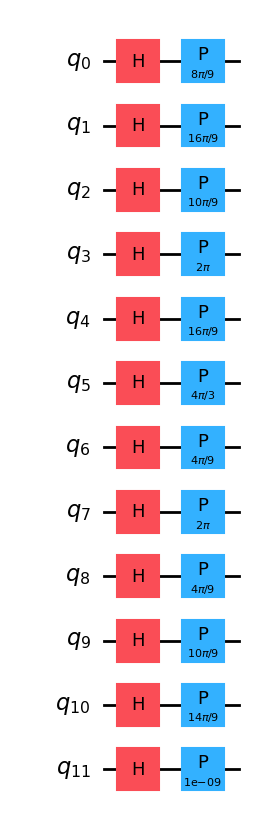

In [14]:
x_vec = [4,8,5,9,8,6,2,9,2,5,7,0]
print(len(x_vec))
print(rescale_vec(x_vec))
phase_encoding(x_vec)

## Dense angle encoding (DAE)

Features:

* combination of angle and phase encoding
* two feature values encoded in a single qubit: one feature with a Y-axis rotation angle, the other feature with a z-axis rotation angle:
\begin{equation}
|\vec{x}_k^{(j)},\vec{x}_l^{(j)}\rangle = R_Z(\phi=\vec{x}_l^{(j)})R_Y(\theta=\vec{x}_k^{(j)})|0\rangle=\cos(\frac{\vec{x}_k^{(j)}}{2})|0\rangle +e^{i\vec{x}_l^{(j)}}\sin(\frac{\vec{x}_k^{(j)}}{2})|1\rangle
\end{equation}
* 2$\times$ reduction in number of qubits required
* to more features this extends to
\begin{equation}
|\vec{x}\rangle = \otimes_{k=1}^{N/2}\cos(x_{2k-1})|0\rangle + e^{ix_{2k}\sin(x_{2k-1})|1\rangle
\end{equation}

Example: Encode the two features $x_1=\theta=3\pi/8$ and $x_2=\phi=7\pi/4$

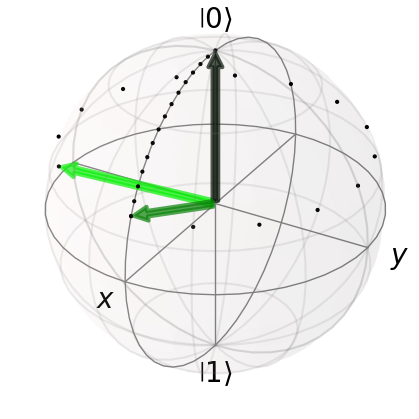

In [15]:
qc = QuantumCircuit(1)
state1 = Statevector.from_instruction(qc)
qc.ry(3 * pi / 8, 0)
state2 = Statevector.from_instruction(qc)
qc.rz(7 * pi / 4, 0)
state3 = Statevector.from_instruction(qc)
states = state1, state2, state3
 
plot_Nstates(states, axis=None, plot_trace_points=True)

As a second example, we take $\vec{x}^{(1)}=(4,8,5,9,8,6,2,9,2,5,7,0,3,7,5)$. Here, we can make us of functions defined before such as the `rescale_vec()` functions, which rescales the values to angles between $(0,2\pi]$

In [37]:
def dense_angle_encoding(vec):
    
    nqubit=math.ceil((len(vec)/2))

    scaled_vec = rescale_vec(vec)
    
    qc = QuantumCircuit(nqubit)

    for nx in range(0,nqubit):
        print(nx,nx+1,nqubit)
        qc.ry(scaled_vec[2*nx], nx)
        if nx+1 != nqubit: qc.rz(scaled_vec[2*nx+1], nx)
        
    return qc.draw("mpl", scale=1)

15
[2.79252680e+00 5.58505361e+00 3.49065850e+00 6.28318531e+00
 5.58505361e+00 4.18879020e+00 1.39626340e+00 6.28318531e+00
 1.39626340e+00 3.49065850e+00 4.88692191e+00 1.00000000e-09
 2.09439510e+00 4.88692191e+00 3.49065850e+00]
0 1 8
1 2 8
2 3 8
3 4 8
4 5 8
5 6 8
6 7 8
7 8 8


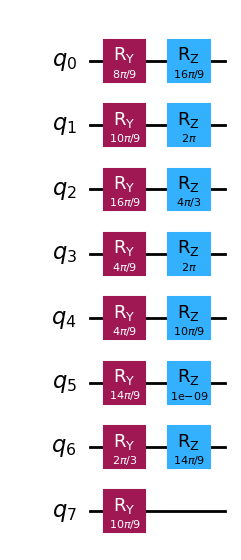

In [38]:
x_vec = [4,8,5,9,8,6,2,9,2,5,7,0,3,7,5]
print(len(x_vec))
print(rescale_vec(x_vec))
dense_angle_encoding(x_vec)

The solution on the IBM website used an additional $R_Z$ with $\phi=0$ for the last qubit.

# Encoding with build-in feature maps

## Encoding at arbitrary points